In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

Load clean data

In [2]:
df=pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vT16qP0TwShFqGZXJq4yLTGq9l-y1sUB9iJRmqRXyIE8RQdAF3c7lRrX0j3uRXcPYK8PD6SwcRXYRaJ/pub?output=csv')
df.head()

,transaction_id,customer_id,category,item,price_per_unit,quantity,total_spent,payment_method,location,date,discount
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10,185.0,Digital Wallet,Online,2024-04-08,True
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9,261.0,Digital Wallet,Online,2023-07-23,True
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2,43.0,Credit Card,Online,2022-10-05,False
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9,247.5,Credit Card,Online,2022-05-07,False
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7,87.5,Digital Wallet,Online,2022-10-02,False


# EDA (Exploratory Data Analysis)

## Trend Analysis: Transactions, Customers, and Products

1️⃣ Transaction Trends: Sales Volume & Revenue Growth<br>
📌 Business Insight:<br>

Helps detect seasonal fluctuations, growth patterns, and potential declining periods.

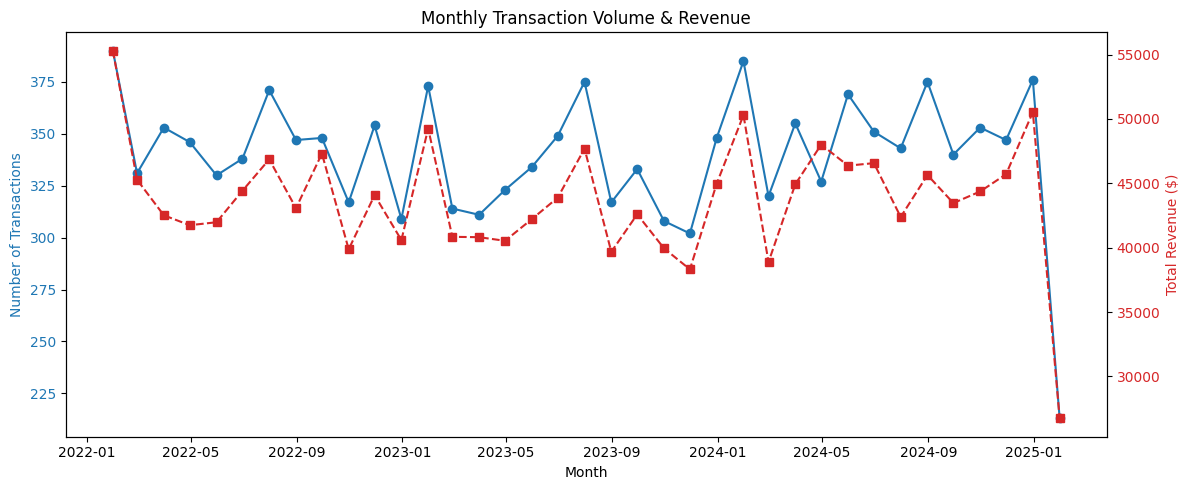

In [3]:
# Ensure date column is in datetime format
df['date'] = pd.to_datetime(df['date'])

# Aggregate monthly transactions & revenue
monthly_sales = df.resample('M', on='date').agg({'transaction_id': 'count', 'total_spent': 'sum'})

# Plot both transaction count and revenue
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.set_title('Monthly Transaction Volume & Revenue')
ax1.set_xlabel('Month')
ax1.set_ylabel('Number of Transactions', color='tab:blue')
ax1.plot(monthly_sales.index, monthly_sales['transaction_id'], marker='o', linestyle='-', color='tab:blue', label='Transactions')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Total Revenue ($)', color='tab:red')
ax2.plot(monthly_sales.index, monthly_sales['total_spent'], marker='s', linestyle='--', color='tab:red', label='Revenue')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.show()


2️⃣ Customer Behavior: New vs. Returning Customers<br>
📌 Business Insight:<br>

Helps businesses track customer retention and acquisition trends over time.

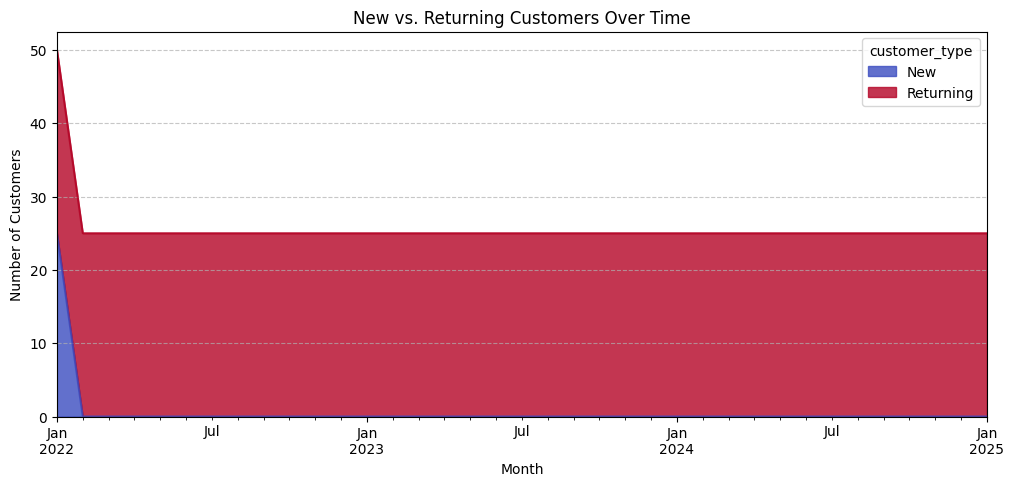

In [4]:
# Identify first purchase date for each customer
df['first_purchase'] = df.groupby('customer_id')['date'].transform('min')

# Categorize customers as 'New' or 'Returning'
df['customer_type'] = df.apply(lambda x: 'New' if x['date'] == x['first_purchase'] else 'Returning', axis=1)

# Aggregate new vs. returning customers over time
customer_trends = df.groupby([df['date'].dt.to_period('M'), 'customer_type'])['customer_id'].nunique().unstack()

# Plot stacked area chart
customer_trends.plot(kind='area', stacked=True, figsize=(12, 5), alpha=0.8, cmap='coolwarm')
plt.title('New vs. Returning Customers Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


3️⃣ Product Performance: Category-Level Revenue Trends<br>
📌 Business Insight:<br>

Which product categories are driving revenue over time?

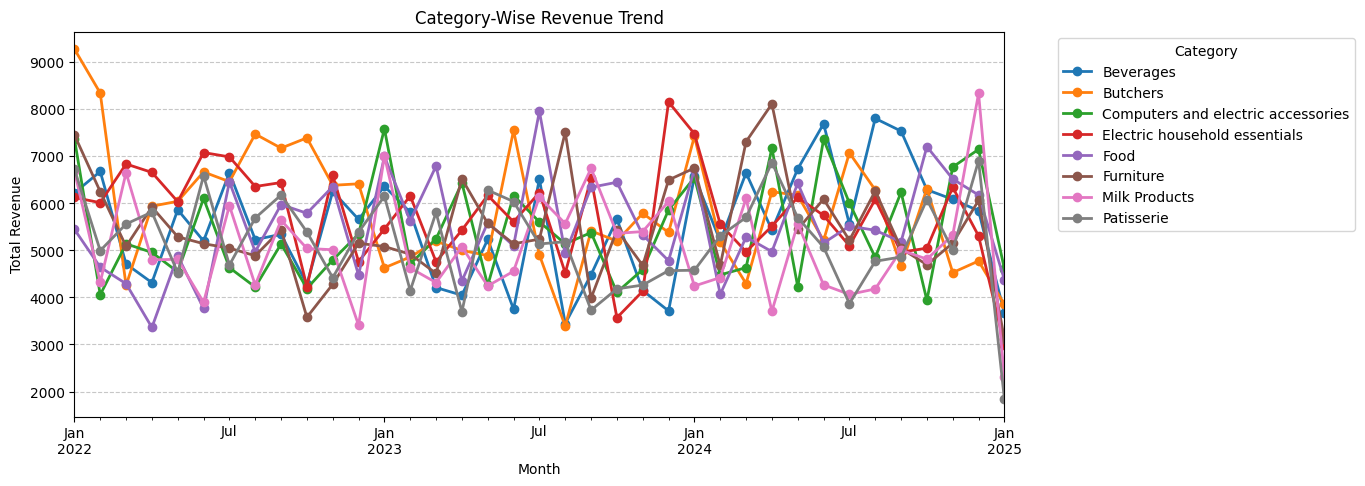

In [5]:
# Aggregate total revenue by category over time
category_trends = df.groupby([df['date'].dt.to_period('M'), 'category'])['total_spent'].sum().unstack()

# Plot category revenue trend
category_trends.plot(kind='line', figsize=(12, 5), marker='o', linewidth=2)
plt.title('Category-Wise Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# RFM Analysis

In [6]:
# Hitung RFM
rfm = df.groupby('customer_id').agg(
    Recency=('date', lambda x: (pd.Timestamp.today() - x.max()).days),
    Frequency=('transaction_id', 'nunique'),
    Monetary=('total_spent', 'sum')  # Total transaksi
).reset_index()

In [7]:
# Hitung AOV (Average Order Value)
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']

In [8]:
rfm.head()

,customer_id,Recency,Frequency,Monetary,AOV
0,CUST_01,54,507,61118.5,120.549310
1,CUST_02,56,488,64325.0,131.813525
2,CUST_03,56,465,62872.5,135.209677
3,CUST_04,54,474,63829.0,134.660338
4,CUST_05,58,544,70012.5,128.699449


## RFM Quartiles

In [9]:
# Define a function to safely apply qcut with dynamic label adjustment
def safe_qcut(series, bins=4, labels=None):
    unique_vals = series.nunique()  # Count unique values
    if unique_vals < bins:  # If not enough unique values, reduce bins
        bins = unique_vals

    try:
        return pd.qcut(series, bins, labels=labels[:bins], duplicates='drop')
    except ValueError:
        # If qcut still fails, use cut as a backup
        return pd.cut(series, bins, labels=labels[:bins], duplicates='drop')

# Apply the function to each RFM metric
rfm['Recency_Quartile'] = safe_qcut(rfm['Recency'], 4, labels=[1, 2, 3, 4])
rfm['Frequency_Quartile'] = safe_qcut(rfm['Frequency'], 4, labels=[4, 3, 2, 1])
rfm['AOV_Quartile'] = safe_qcut(rfm['AOV'], 4, labels=[4, 3, 2, 1])

In [10]:
rfm

,customer_id,Recency,Frequency,Monetary,AOV,Recency_Quartile,Frequency_Quartile,AOV_Quartile
0,CUST_01,54,507,61118.5,120.549310,1,2,4
1,CUST_02,56,488,64325.0,131.813525,2,3,1
2,CUST_03,56,465,62872.5,135.209677,2,4,1
3,CUST_04,54,474,63829.0,134.660338,1,4,1
4,CUST_05,58,544,70012.5,128.699449,3,1,3
5,CUST_06,56,481,60911.0,126.634096,2,4,3
6,CUST_07,54,491,63949.5,130.243381,1,3,2
7,CUST_08,55,533,70172.5,131.655722,1,1,1
8,CUST_09,55,519,63702.0,122.739884,1,1,4
9,CUST_10,54,501,65325.5,130.390220,1,3,2


## Customer Segmentation

In [11]:
def segment_customer(row):
    r, f, m = row['Recency_Quartile'], row['Frequency_Quartile'], row['AOV_Quartile']

    # 1. Best Customer
    if r == 1 and f == 1 and m == 1:
        return 'Best Customer'
    # 2. Potential Customers
    elif (r == 1 and f == 1 and m == 2) or \
         (r == 1 and f == 2 and m == 2) or \
         (r == 2 and f == 1 and m == 1) or \
         (r == 2 and f == 2 and m == 2):
        return 'Potential Customers'
    # 3. Lost Cheap
    elif r == 4 and f == 4 and m in [4, 3]:
        return 'Lost Cheap'
    # 4. Big Spender
    elif m == 1:
        return 'Big Spender'
    # 5. Loyal Customers
    elif f == 1:
        return 'Loyal Customers'
    # 6. Others/Recent Shopper
    elif (r == 1 or r == 2):
        return 'Others/Recent Shopper'
    # 7. Almost Lost
    elif r == 3:
        return 'Almost Lost'
    # 8. Lost Customers
    elif r == 4:
        return 'Lost Customers'

    # Default: Segmen tidak dikenal
    else:
        return 'Others'

# Tambahkan kolom segmentasi ke DataFrame
rfm['Segment'] = rfm.apply(segment_customer, axis=1)


In [12]:
# Tambahkan kolom RFM Score sebagai kombinasi tiga angka
rfm['RFM_Score'] = (
    rfm['Recency_Quartile'].astype(str) +
    rfm['Frequency_Quartile'].astype(str) +
    rfm['AOV_Quartile'].astype(str)
)

In [13]:
rfm

,customer_id,Recency,Frequency,Monetary,AOV,Recency_Quartile,Frequency_Quartile,AOV_Quartile,Segment,RFM_Score
0,CUST_01,54,507,61118.5,120.549310,1,2,4,Others/Recent Shopper,124
1,CUST_02,56,488,64325.0,131.813525,2,3,1,Big Spender,231
2,CUST_03,56,465,62872.5,135.209677,2,4,1,Big Spender,241
3,CUST_04,54,474,63829.0,134.660338,1,4,1,Big Spender,141
4,CUST_05,58,544,70012.5,128.699449,3,1,3,Loyal Customers,313
5,CUST_06,56,481,60911.0,126.634096,2,4,3,Others/Recent Shopper,243
6,CUST_07,54,491,63949.5,130.243381,1,3,2,Others/Recent Shopper,132
7,CUST_08,55,533,70172.5,131.655722,1,1,1,Best Customer,111
8,CUST_09,55,519,63702.0,122.739884,1,1,4,Loyal Customers,114
9,CUST_10,54,501,65325.5,130.390220,1,3,2,Others/Recent Shopper,132


In [14]:
# Merge RFM table with original DataFrame
df_merged = df.merge(rfm, on='customer_id', how='left')

# Save the merged DataFrame to an Excel file
output_file = "Retail_RFM_Analysis.xlsx"
df_merged.to_excel(output_file, index=False)

print(f"File has been saved to: {output_file}")

File has been saved to: Retail_RFM_Analysis.xlsx


In [15]:
df_merged.head()

,transaction_id,customer_id,category,item,price_per_unit,quantity,total_spent,payment_method,location,date,...,customer_type,Recency,Frequency,Monetary,AOV,Recency_Quartile,Frequency_Quartile,AOV_Quartile,Segment,RFM_Score
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10,185.0,Digital Wallet,Online,2024-04-08,...,Returning,55,519,63702.0,122.739884,1,1,4,Loyal Customers,114
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9,261.0,Digital Wallet,Online,2023-07-23,...,Returning,57,501,64662.0,129.065868,2,3,3,Others/Recent Shopper,233
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2,43.0,Credit Card,Online,2022-10-05,...,Returning,56,488,64325.0,131.813525,2,3,1,Big Spender,231
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9,247.5,Credit Card,Online,2022-05-07,...,Returning,56,481,60911.0,126.634096,2,4,3,Others/Recent Shopper,243
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7,87.5,Digital Wallet,Online,2022-10-02,...,Returning,58,544,70012.5,128.699449,3,1,3,Loyal Customers,313


## RFM Visualization

In [16]:
# Set figure size and style
plt.style.use('ggplot')

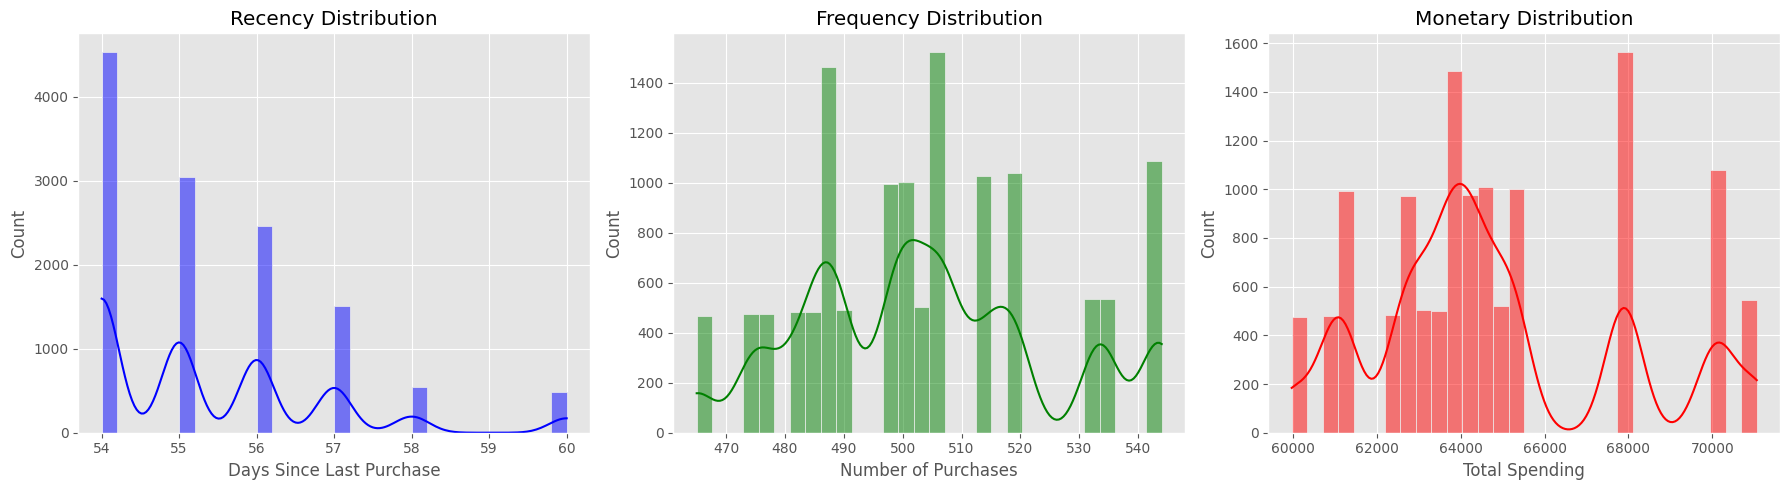

In [17]:
# Plot 1: Distribution of Recency, Frequency, and Monetary Values
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(df_merged['Recency'], bins=30, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days Since Last Purchase')

sns.histplot(df_merged['Frequency'], bins=30, kde=True, ax=axes[1], color='green')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of Purchases')

sns.histplot(df_merged['Monetary'], bins=30, kde=True, ax=axes[2], color='red')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total Spending')

plt.tight_layout()
plt.show()

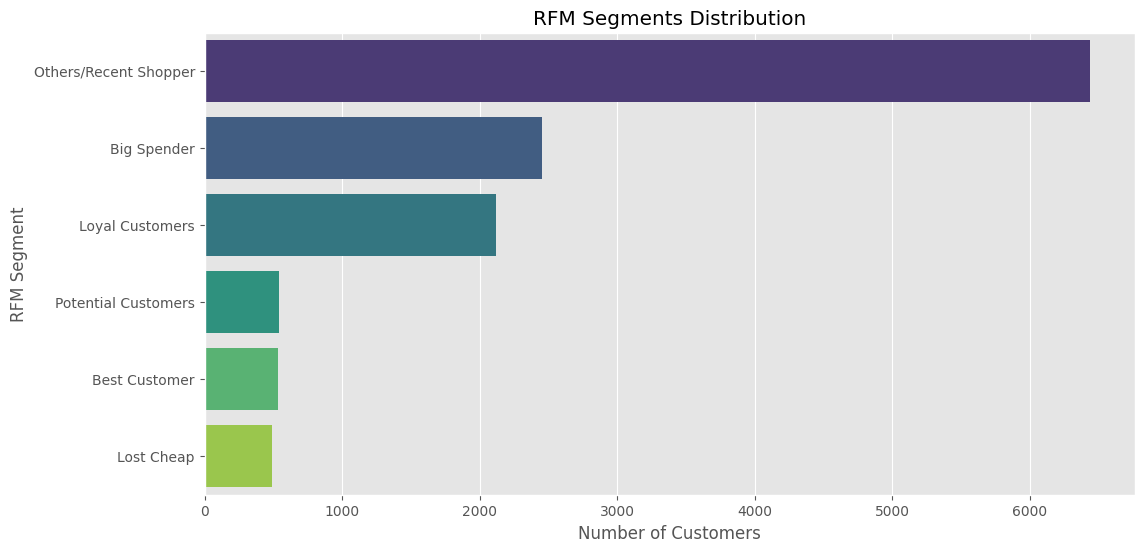

In [18]:
# Plot 2: RFM Segments Count
plt.figure(figsize=(12, 6))
sns.countplot(y=df_merged['Segment'], order=df_merged['Segment'].value_counts().index, palette='viridis')
plt.title('RFM Segments Distribution')
plt.xlabel('Number of Customers')
plt.ylabel('RFM Segment')
plt.show()

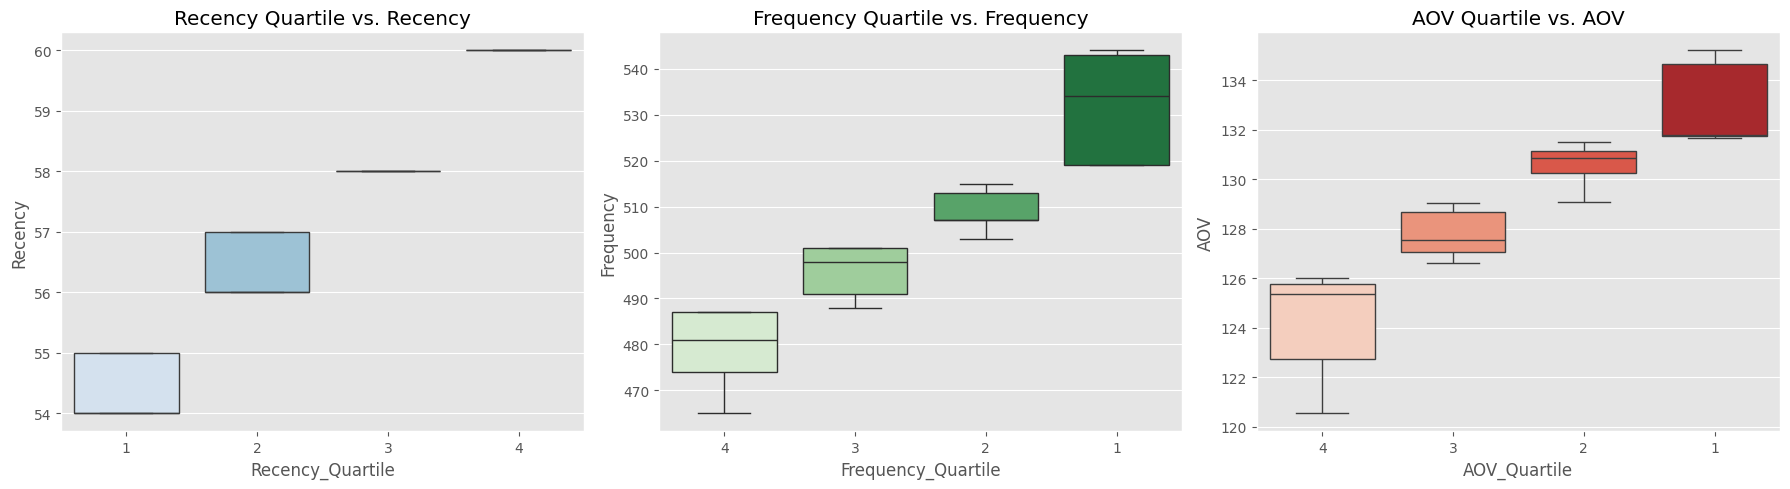

In [19]:
# Plot 3: Boxplots for RFM Quartiles
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x=df_merged['Recency_Quartile'], y=df_merged['Recency'], ax=axes[0], palette='Blues')
axes[0].set_title('Recency Quartile vs. Recency')

sns.boxplot(x=df_merged['Frequency_Quartile'], y=df_merged['Frequency'], ax=axes[1], palette='Greens')
axes[1].set_title('Frequency Quartile vs. Frequency')

sns.boxplot(x=df_merged['AOV_Quartile'], y=df_merged['AOV'], ax=axes[2], palette='Reds')
axes[2].set_title('AOV Quartile vs. AOV')

plt.tight_layout()
plt.show()

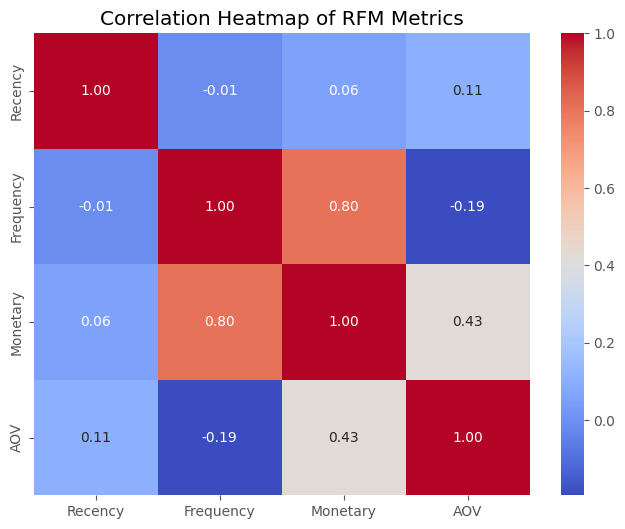

In [20]:
# Plot 4: Heatmap for RFM Score Correlation
plt.figure(figsize=(8, 6))
rfm_corr = df_merged[['Recency', 'Frequency', 'Monetary', 'AOV']].corr()
sns.heatmap(rfm_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of RFM Metrics')
plt.show()

# CLV

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [23]:
# Step 1: Prepare Features and Target Variable
features = ['Recency', 'Frequency', 'Monetary', 'AOV', 'customer_type', 'payment_method', 'location']
target = 'total_spent'  # Predicting total spending for the next 3 months

df_clv = df_merged[features + [target]].copy()


In [24]:
# Step 2: Encode Categorical Variables
label_encoders = {}
for col in ['customer_type', 'payment_method', 'location']:
    le = LabelEncoder()
    df_clv[col] = le.fit_transform(df_clv[col])
    label_encoders[col] = le  # Store encoders for future use

In [25]:
# Step 3: Split Data into Training and Testing Sets
X = df_clv.drop(columns=[target])
y = df_clv[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Step 4: Define 10 Different Regression Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "ElasticNet Regression": ElasticNet(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "AdaBoost Regressor": AdaBoostRegressor(n_estimators=100, random_state=42),
    "Extra Trees Regressor": ExtraTreesRegressor(n_estimators=100, random_state=42),
    "Support Vector Regressor": SVR(kernel='rbf', C=100, gamma=0.1),
    "KNN Regressor": KNeighborsRegressor(n_neighbors=5)
}

In [27]:
# Step 5: Train and Evaluate Each Model
evaluation_results = []

for model_name, model in models.items():
    # Train model
    model.fit(X_train, y_train)

    # Predict on test set
    y_pred = model.predict(X_test)

    # Compute evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    # Store results
    evaluation_results.append({
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    })

# Convert results to DataFrame
eval_df = pd.DataFrame(evaluation_results)

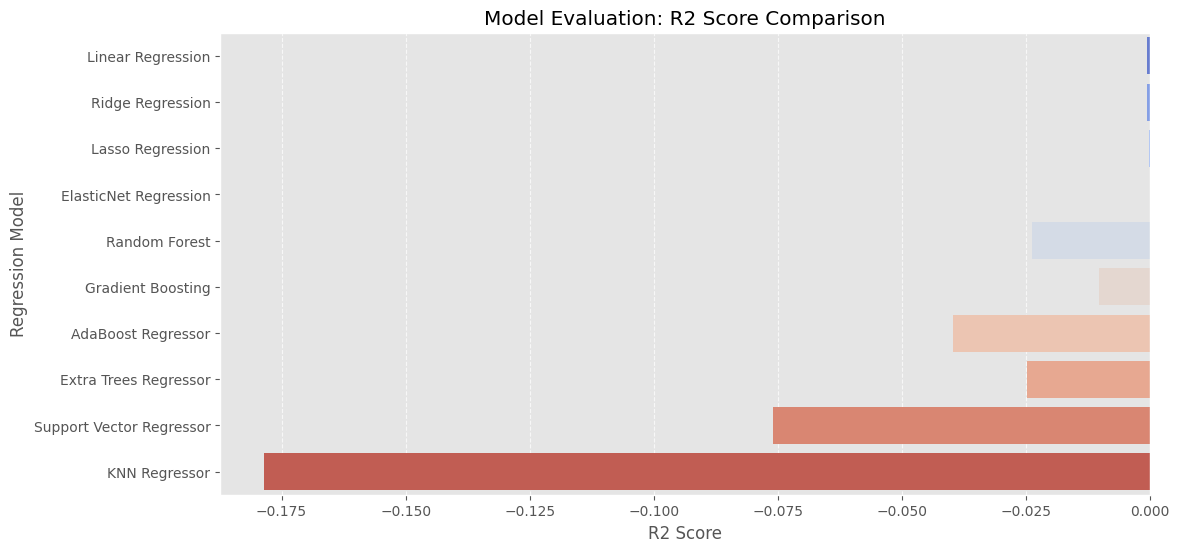

Model Evaluation Results:
                      Model        MAE           MSE        RMSE  R2 Score
3     ElasticNet Regression  75.675945   8781.279591   93.708482 -0.000127
2          Lasso Regression  75.677738   8781.538598   93.709864 -0.000157
1          Ridge Regression  75.686408   8786.344102   93.735501 -0.000704
0         Linear Regression  75.686934   8786.510836   93.736390 -0.000723
5         Gradient Boosting  76.030122   8869.922072   94.180264 -0.010223
4             Random Forest  76.417563   8988.720612   94.808864 -0.023753
7     Extra Trees Regressor  76.447660   8997.637359   94.855877 -0.024769
6        AdaBoost Regressor  80.574862   9129.730664   95.549624 -0.039813
8  Support Vector Regressor  74.245381   9447.094423   97.196165 -0.075959
9             KNN Regressor  81.695905  10346.948286  101.719950 -0.178446


In [28]:
# Step 6: Plot Model Performance
plt.figure(figsize=(12, 6))
sns.barplot(data=eval_df, x="R2 Score", y="Model", palette="coolwarm")
plt.title("Model Evaluation: R2 Score Comparison")
plt.xlabel("R2 Score")
plt.ylabel("Regression Model")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Display Evaluation Results
print("Model Evaluation Results:")
print(eval_df.sort_values(by="R2 Score", ascending=False))

In [30]:
# Step 7: Select the Best Model (Highest R2 Score)
best_model_name = eval_df.sort_values(by="R2 Score", ascending=False).iloc[0]["Model"]
best_model = models[best_model_name]
best_model

ElasticNet(alpha=0.1)

In [31]:
# Step 8: Predict CLV for Next 3 Months using the Best Model
df_clv['predicted_CLV_3m'] = best_model.predict(X)

In [37]:
# Step 9: Show Predicted CLV
# Keep customer_id separately before training
df_clv_full = df_merged[['customer_id'] + features + [target]].copy()

# Encode categorical variables
for col in ['customer_type', 'payment_method', 'location']:
    df_clv_full[col] = label_encoders[col].transform(df_clv_full[col])

# Separate customer_id before model training
customer_ids = df_clv_full[['customer_id']]
df_clv = df_clv_full.drop(columns=['customer_id'])

# Predict CLV for Next 3 Months
df_clv['predicted_CLV_3m'] = best_model.predict(df_clv.drop(columns=[target]))

# Merge back customer_id
df_clv_final = pd.concat([customer_ids, df_clv[['predicted_CLV_3m']]], axis=1)

# Sort CLV predictions
clv_sorted = df_clv_final.sort_values(by='predicted_CLV_3m', ascending=False)

# Display results
print("\nPredicted CLV for Next 3 Months:")
print(clv_sorted)



Predicted CLV for Next 3 Months:
      customer_id  predicted_CLV_3m
6570      CUST_04        136.280521
7530      CUST_04        136.280521
5928      CUST_04        136.280521
12050     CUST_04        136.280521
4296      CUST_04        136.280521
...           ...               ...
6388      CUST_01        119.226984
1079      CUST_01        119.226984
1075      CUST_01        119.226984
6651      CUST_01        119.226984
1260      CUST_01        119.226984

[12575 rows x 2 columns]


In [45]:
# Ensure CLV predictions have unique customer_id values
clv_unique = clv_sorted.groupby("customer_id").agg({"predicted_CLV_3m": "mean"}).reset_index()

# Merge without expanding rows
df_merged_clv = df_merged.merge(clv_unique, on="customer_id", how="left")

# Check the shape before and after merging
print("Original df_merged shape:", df_merged.shape)
print("Merged df_merged_clv shape:", df_merged_clv.shape)

# Display the first few rows
df_merged_clv.head()


Original df_merged shape: (12575, 22)
Merged df_merged_clv shape: (12575, 23)


,transaction_id,customer_id,category,item,price_per_unit,quantity,total_spent,payment_method,location,date,...,Recency,Frequency,Monetary,AOV,Recency_Quartile,Frequency_Quartile,AOV_Quartile,Segment,RFM_Score,predicted_CLV_3m
0,TXN_6867343,CUST_09,Patisserie,Item_10_PAT,18.5,10,185.0,Digital Wallet,Online,2024-04-08,...,55,519,63702.0,122.739884,1,1,4,Loyal Customers,114,121.720349
1,TXN_3731986,CUST_22,Milk Products,Item_17_MILK,29.0,9,261.0,Digital Wallet,Online,2023-07-23,...,57,501,64662.0,129.065868,2,3,3,Others/Recent Shopper,233,128.000777
2,TXN_9303719,CUST_02,Butchers,Item_12_BUT,21.5,2,43.0,Credit Card,Online,2022-10-05,...,56,488,64325.0,131.813525,2,3,1,Big Spender,231,131.357883
3,TXN_9458126,CUST_06,Beverages,Item_16_BEV,27.5,9,247.5,Credit Card,Online,2022-05-07,...,56,481,60911.0,126.634096,2,4,3,Others/Recent Shopper,243,126.451093
4,TXN_4575373,CUST_05,Food,Item_6_FOOD,12.5,7,87.5,Digital Wallet,Online,2022-10-02,...,58,544,70012.5,128.699449,3,1,3,Loyal Customers,313,126.103229


In [47]:
# Save the merged DataFrame with CLV predictions to a CSV file
output_file_clv = "Retail_RFM_CLV_Analysis.csv"
df_merged_clv.to_csv(output_file_clv, index=False)

print(f"File has been saved to: {output_file_clv}")

File has been saved to: Retail_RFM_CLV_Analysis.csv


In [48]:
# Save the merged DataFrame with CLV predictions to an Excel file
output_file_clv = "Retail_RFM_CLV_Analysis.xlsx"
df_merged_clv.to_excel(output_file_clv, index=False)

print(f"File has been saved to: {output_file_clv}")

File has been saved to: Retail_RFM_CLV_Analysis.xlsx
